<a href="https://colab.research.google.com/github/BC-Chang/LBM_Workshop/blob/master/D2Q9_LBM_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Digital Porous Media Industrial Affiliates Program (DPM-IAP) Workshop
### Dr. Masa Prodanovic and Bernard Chang


In this first hands-on activity, we will demonstrate the general algorithm used to perform single phase lattice Boltzmann simulations. The ultimate goal of this exercise is to calculate the velocity field through a given medium. From there, we will demonstrate some visualizations of the velocity field and obtain a value for the permeability through this domain. This example is performed on a 2-dimensional lattice with 9 discrete velocities (D2Q9).

Before we get started, let's import some packages


In [1]:
#@title Import Packages
%%capture
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import tifffile

# Porespy for generating domains
try:
  import porespy as ps
except:
  !pip install -q porespy==1.0.0
  import porespy as ps

from skimage.measure import regionprops,label

import sys
import os
from tqdm import tqdm

try:
  os.chdir("./LBM_Workshop")
  # sys.path.append("./LBM_Workshop/")
except:
  !git clone https://github.com/BC-Chang/LBM_Workshop.git
  os.chdir("./LBM_Workshop")

from plotting_utils import plot_profile, plot_quiver, plot_streamlines

# Import a timer
from time import perf_counter_ns, sleep

# Import ipywidgets
import ipywidgets as widgets
from ipywidgets import interact, interact_manual, interactive
from IPython.display import display, clear_output

import torch


## A Step-by-Step Introduction to the Lattice Boltzmann Method

### Background
The fundamental variable in **kinetic theory**, on which LBM is based, is the particle distribution function $f(x, \xi, t)$. It simultaneously represents mass density in physical space and in velocity space. In other words, $f$ represents the density of particles with particle velocity, $\xi$, at position $x$ and time $t$

The distribution function, $f$, is also related to macroscopic variables such as density, $\rho$ and fluid velocity, $u$ through its **moments**. These moments are integrals of $f$, weighted with some function of $\xi$. For example, the macroscopic mass density can be found as:
$$\rho(x, t) = \int f(x,\xi,t)d^3\xi.$$

Similarly, the momentum density is,
$$\rho(x, t)u(x,t) = \int \xi f(x, \xi, t)d^3\xi.$$


In LBM, we deal with the *discrete-velocity distribution function, $f_i(x, t)$*. The mass density, $\rho$, and the momentum density, $u$, are found through the weighted sums (moments) of $f_i$:
$$\rho = \sum f_i(x, t),$$
and
$$\rho u(x,t) = \sum c_i f_i(x, t),$$

where $c_i$ is a discrete set of velocities discussed below.

### Defining our Lattice

For this exercise, we will use a 2-dimensional lattice with 9 discrete velocities (D2Q9). This means, that in every grid space, there are 9 possible connections — North, South, East, West, 4 diagonal connections and 1 connection from the node itself, representing zero velocity.

Each lattice direction also has a weight, $w_i$ associated with it. For D2Q9 LBM, these will be:

<img src='https://media.springernature.com/full/springer-static/image/art%3A10.1007%2Fs11831-019-09347-7/MediaObjects/11831_2019_9347_Fig2_HTML.png?as=webp' height="300">


In the following cell, we will initialize these velocity directions and their weights.


In [2]:
def initialize_weights():

  # Define lattice velocity vectors
  ex = np.array([0, 1, 0, -1, 0, 1, -1, -1, 1], dtype=np.double)
  ey = np.array([0, 0, 1, 0, -1, 1, 1, -1, -1], dtype=np.double)
  # c = np.array([[0, 0], [1, 0], [0, 1], [-1, 0], [0, -1], [1, 1], [-1, 1], [-1, -1], [1, -1]])


  # Define weights
  w_i = np.array([4./9.,
                  1./9.,
                  1./9.,
                  1./9.,
                  1./9.,
                  1./36.,
                  1./36.,
                  1./36.,
                  1./36.], dtype=np.double)
  
  return ex, ey, w_i

<!-- The fundamental variable in **kinetic theory**, on which LBM is based, is the particle distribution function $f(x, \xi, t)$. It simultaneously represents mass density in physical space and in velocity space. In other words, $f$ represents the density of particles with particle velocity, $\xi$, at position $x$ and time $t$

The distribution function, $f$, is also related to macroscopic variables such as density, $\rho$ and fluid velocity, $u$ through its **moments**. These moments are integrals of $f$, weighted with some function of $\xi$. For example, the macroscopic mass density can be found as:
$$\rho(x, t) = \int f(x,\xi,t)d^3\xi.$$

Similarly, the momentum density is,
$$\rho(x, t)u(x,t) = \int \xi f(x, \xi, t)d^3\xi.$$ -->

### Obtaining Macroscopic Properties

Recall  that macroscopic properties, such as mass and momentum density can be can be obtained from the weighted sum (moments) of the *discrete-velocity distribution function, $f_i(x, t)$*
<!-- In LBM, we deal with the *discrete-velocity distribution function, $f_i(x, t)$*. The mass density, $\rho$, and the momentum density, $u$, are found through the weighted sums (moments) of $f_i$: -->
$$\rho = \sum f_i(x, t),$$
and
$$\rho u(x,t) = \sum c_i f_i(x, t),$$

where $c_i$ is a discrete set of particle velocities. 


In [3]:
def macroscopic(f, fx, fy, ex, ey, nx, ny):
  """
  :f: Discrete particle distribution function
  :fx: Row indices of fluid nodes
  :fy: Column indices of fluid nodes
  :c: Velocity vectors
  :nx: Domain size in x
  :ny: Domain size in y
  :returns: density, velocity components in x and y
  """
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  # Initialize outputs to 0s
  u_x = torch.zeros((nx, ny), dtype=torch.float64).to(device)
  u_y = torch.zeros((nx, ny), dtype=torch.float64).to(device)
  rho = torch.zeros((nx, ny), dtype=torch.float64).to(device)

  # Calculate macroscopic properties from moments. Only calculate where there are fluid nodes
  # Density
  rho[fx, fy] += torch.sum(f[:, fx, fy], axis=0)

  # Velocity
  u_x[fx, fy] += torch.sum(ex[:, None] * f[:, fx, fy], axis=0)
  u_y[fx, fy] += torch.sum(ey[:, None] * f[:, fx, fy], axis=0)
  u_x[fx, fy] = u_x[fx, fy] / rho[fx, fy]
  u_y[fx, fy] = u_y[fx, fy] / rho[fx, fy]

  return rho, u_x, u_y


### Equilibrium Calculation

Recall the *lattice Boltzmann equation* from the discretization of the Boltzmann equation:
$$f_i(x + c_i\Delta t, t + \Delta t) = f_i(x, t) + \Omega_i(x, t)$$

This shows that the particles $f_i(x,t)$ move with velocity $c_i$ to a neighboring node. At the same time, the movement of particles is affected by the collision operator, $\Omega_i$.

After particles collide, we may assume that $f_i$ will reach an equilibrium distribution, $f^{eq}$. This equilibrium is given by:

$$ f_i^{eq}(x, t) = w_i \rho \left(1 + \frac{u \cdot c_i}{c_s^2} + \frac{(u \cdot c_i)^2}{2c_s^4} - \frac{u \cdot u}{2c_s^2} \right).$$

In the isothermal lattice Boltzmann equation, $c_s$ determines the relationship between pressure and density as $p = c_s^2 \rho$. It can be shown that $c_s$ represents the model's *speed of sound*. In all velocity sets that we will deal with today, $$c_s^2 = (1/3)\Delta x^2 / \Delta t^2.$$

We typically operate in lattice units, where $\Delta x = \Delta t = 1$. Therefore, the equilibrium distribution function can be simplified to

$$ f_i^{eq}(x, t) = w_i \rho \left(1 + 3(u \cdot c_i) + \frac{9}{2}(u \cdot c_i)^2 - \frac{3}{2} (u \cdot u) \right).$$



In [4]:
def equilibrium(rho, ux, uy, ex, ey, w_i, nx, ny, fx, fy, tau, g):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  # Extract only fluid nodes and add forcing to velocity
  ux = ux[fx, fy] + tau*g
  uy = uy[fx, fy]

  feq = torch.zeros((9, nx, ny), dtype=torch.float64).to(device)

  for i in range(9):
    # Compute 2nd term in parenthesis of feq equation above
    uc = ex[i]*ux + ey[i]*uy
    feq[i, fx, fy] = rho[fx, fy] * w_i[i] * (1 + 3*uc + (9./2.)*uc**2 - (3./2.)*(ux**2 + uy**2))

  return feq

### Collision Step

Lattice Boltzmann Simulations can be boiled down to two main steps: **collision** and **streaming**. 

The simplest collision operator, and the one we will use for this exercise, is the Bhatnagar-Gross-Krook (BGK) operator:

$$\Omega_i(f) = -\frac{f_i - f_i^{eq}}{\tau} \Delta t.$$

This operator relaxes toward equilibrium at a rate determined by the relaxation time $\tau$.

#### Bounceback Boundary Condition

In this exercise, we assume no slip boundary conditions at solid node boundaries. We implement this using the bounceback method. 

<img src='https://lh5.googleusercontent.com/zGWX3SZ4XPnPo1Y3ujyolWPc-e0UEWAP793DhU3wkjLYQzHTUQooNpzTBRpzz-e1rRhs_BSGl32tOqMYGYjAgXkJorzjR1Nc0iRbKRnbrfYH-cn5_t2tbQdqGOPfdbK9V0VSl_63SGjKlmyI0_kULidN3xAOG1FyyUsM=w1280'>

In [5]:
def collision(f, feq, tau, sx, sy, fx, fy):     
    # Standard Bounceback for Solid Nodes
    # Left-Right
    f[1, sx, sy], f[3, sx, sy] = f[3, sx, sy], f[1, sx, sy]

    # Up-Down
    f[2, sx, sy], f[4, sx, sy] = f[4, sx, sy], f[2, sx, sy]

    # Top Right - Bottom Left
    f[5, sx, sy], f[7, sx, sy] = f[7, sx, sy], f[5, sx, sy]

    # Top Left - Bottom Right
    f[6, sx, sy], f[8, sx, sy]  = f[8, sx, sy], f[6, sx, sy]

    # Regular collision in fluid nodes
    f[:, fx, fy] -= (f[:, fx, fy] - feq[:, fx, fy]) / tau

    return f

### Streaming Step

The other main step in simulations is the streaming step. This simply means that particles will move to a neighboring node with velocity $c_i$.

In practice, we just need to ensure that we implement the streaming step in such a way that we do not overwrite data that we will need later. In Python, we can use the function ```numpy.roll()```. 

In the following cell, we visualize how the ```numpy.roll()``` function operates:

In [6]:
def roll_visualization(roll_x_dir, roll_y_dir):

  field_x = np.ones((100, 100))
  linear = np.linspace(0, 99, 100)
  field_x *= linear

  field_y = field_x.copy().T

  field = field_x + field_y
  plt.imshow(field)
  plt.gca().invert_yaxis()
  plt.show()

  for i in range(201):
    field = np.roll(field, (roll_x_dir, roll_y_dir), axis=(1, 0))
    if i % 5 == 0:
      sleep(0.005)
      clear_output(wait=True)
      plt.imshow(field)
      plt.gca().invert_yaxis()
      plt.show()
       
  # display(roll_x, roll_y)

roll_x = widgets.IntSlider(value=0, min=-1, max=1, description='x_direction', continuous_update=False)
roll_y = widgets.IntSlider(value=0, min=-1, max=1, description='y_direction', continuous_update=False)

interactive_plot = widgets.interactive(roll_visualization, {'manual': True},
                                       roll_x_dir=widgets.IntSlider(min=-1, max=1), 
                                       roll_y_dir=widgets.IntSlider(min=-1, max=1))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=0, description='roll_x_dir', max=1, min=-1), IntSlider(value=0, descript…

### Putting it all together

Putting the above steps into a time loop will give us our first simulator! 

Our first example will be simulating the flow around a cylinder, known as the Karman vortex street — considered a "Hello, World!" of LBM simulations.

The general steps are as follows:
1. Initialize simulation parameters, including:
  - Relaxation Time
  - Force
  - Average density
  - Convergence metrics

2. Initialize velocity vectors and weights
3. Process domain to separate fluid and solid nodes
4. Perform time loop

The following is performed inside the time loop:

1. Compute macroscopic parameters $\rho$ and $u$
2. Add forcing to the velocities. This is one example for how we can drive flow
3. Calculate $f^{eq}$
4. Collision
  - Bounceback for solid nodes
  - BGK Collision for fluid nodes
5. Streaming

In [7]:
def run_lbm(data):

    # Initialization
    tau = 1.0  # Relaxation time
    g = 0.00001  # Gravity or other force
    density = 1.
    tf = 10001  # Maximum number of iteration steps
    precision = 1.E-5  # Convergence criterion
    vold = 1000
    eps = 1E-6

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    data = torch.tensor(data).to(device)
    check_convergence = 30  # Check convergence every [check_convergence] time steps

    # Define lattice velocity vectors
    ex, ey, w_i = initialize_weights()
    ex = torch.tensor(ex).to(device)
    ey = torch.tensor(ey).to(device)
    w_i = torch.tensor(w_i).to(device)

    # Indices of fluid nodes
    fluid_id = torch.argwhere(data == 0).to(device)
    fx = fluid_id[:, 0]
    fy = fluid_id[:, 1]

    # Indices of solid nodes
    solid_id = torch.argwhere(data == 1).to(device)
    sx = solid_id[:, 0]
    sy = solid_id[:, 1]

    # Solid nodes are labeled 1, fluid nodes are labeled 0
    is_solid_node = data

    nx, ny = data.shape

    # Initialize distribution functions
    f = w_i * density
    # Broadcast to 3D array with each slice corresponding to a direction's weights
    f = torch.tile(f[:, None, None], (nx, ny)).type(torch.float64).to(device)

    # Allocate memory to equilibrium functions
    feq = torch.empty_like(f, dtype=torch.float64).to(device)

    # Each point has x-component ex, and y-component ey
    u_x = torch.empty((nx, ny), dtype=torch.float64).to(device)
    u_y = torch.empty((nx, ny), dtype=torch.float64).to(device)

    # Node density
    rho = torch.zeros((nx, ny), dtype=torch.float64)

    # # Begin time loop
    tic = perf_counter_ns()
    for ts in tqdm(range(tf)):
        # print(f"{ts = }")  # Print timestep

        # Compute macroscopic density, rho and velocity.
        rho, u_x, u_y = macroscopic(f, fx, fy, ex, ey, nx, ny)

        # Add forcing to velocity and compute equilibrium function
        feq = equilibrium(rho, u_x, u_y, ex, ey, w_i, nx, ny, fx, fy, tau, g)

        # Collision Step
        f = collision(f, feq, tau, sx, sy, fx, fy)

        # Streaming Step
        f[1] = torch.roll(f[1], 1, dims=1)
        f[2] = torch.roll(f[2], 1, dims=0)
        f[3] = torch.roll(f[3], -1, dims=1)
        f[4] = torch.roll(f[4], -1, dims=0)

        f[5] = torch.roll(f[5], (1, 1), dims=(0,1))
        f[6] = torch.roll(f[6], (-1, 1), dims=(1,0))
        f[7] = torch.roll(f[7], (-1, -1), dims=(0,1))
        f[8] = torch.roll(f[8], (1, -1), dims=(1,0))

        # Calculate velocity
        u = torch.sqrt(u_x**2 + u_y**2)

        # Check convergence every check_convergence time step
        if ts % check_convergence == 0:

            vnew = torch.mean(u)
            error = torch.abs(vold - vnew) / (vold+eps)
            vold = vnew

            if error < precision:
                print(f'Simulation has converged in {ts} time steps')
                break

        if ts == tf:
            print('Reached maximum iterations')

    toc = perf_counter_ns()
    print(f"Elapsed Time: {(toc - tic)*1E-9}s")

    u_x = u_x.to('cpu')
    u_y = u_y.to('cpu')
    u = u.to('cpu')

    return u_x, u_y, u

###  Read in the geometry
Before we get into the flow simulation, let's first read in our geometry. For this exercise, we assume a 2D binary image with:
- 0 indicating fluid space
- 1 indicating solid space

For this workshop, we select an image from the data folder. You can also load in your own image or create one yourself if you'd like.


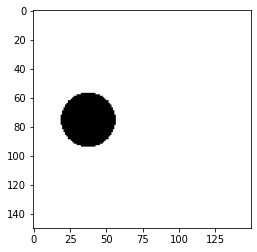

In [21]:
Nx = 150
Ny = 150
X, Y = np.meshgrid(range(Nx), range(Ny))
data = (X - Nx/4)**2 + (Y - Ny/2)**2 < (Ny/8)**2

plt.imshow(data, cmap='binary')


Let's run our LBM simulation! This simulation does not fully converge in the default number of iterations, but it gets the point across. This should take about one minute to run. 

In [9]:
u_x, u_y, u = run_lbm(data)

100%|██████████| 10001/10001 [00:51<00:00, 192.49it/s]

Elapsed Time: 51.969259129s


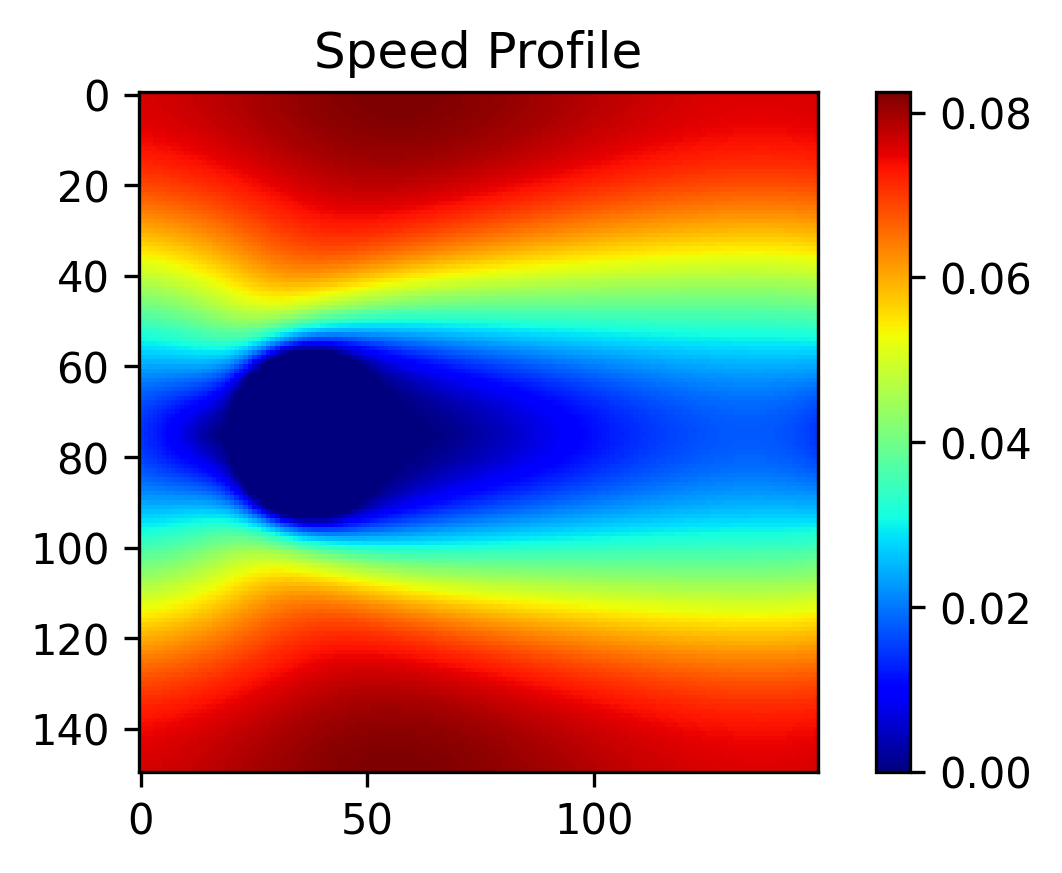

In [10]:
_ = plot_profile(u, cmap='jet')

In [29]:
#@title Read in data
geom_options = os.listdir("./data/")

# TODO create catalog of images, read in from drop down, and plot. 
data_dropdown = widgets.Dropdown(
    concise=False,
    options=geom_options,
    value='beads.tif',
    description='Select a file to read in'
)

# select_button = widgets.Button(description='I want this one!')
# output = widgets.Output()
def read_in_and_plot(dropdown):
  display(dropdown)
  data = tifffile.imread(os.path.join("./data/", dropdown))
  clear_output(wait=True)
  display(dropdown)
  plt.imshow(data, cmap='binary')
  plt.colorbar()
  plt.show()

  return data

widget = widgets.interactive(read_in_and_plot, dropdown=geom_options)
display(widget)


interactive(children=(Dropdown(description='dropdown', options=('beads.tif', 'bevo.tif'), value='beads.tif'), …

In [28]:
data = widget.result
u_x, u_y, u = run_lbm(data)


 91%|█████████ | 9060/10001 [00:28<00:02, 314.24it/s]

Simulation has converged in 9060 time steps
Elapsed Time: 28.835511375000003s


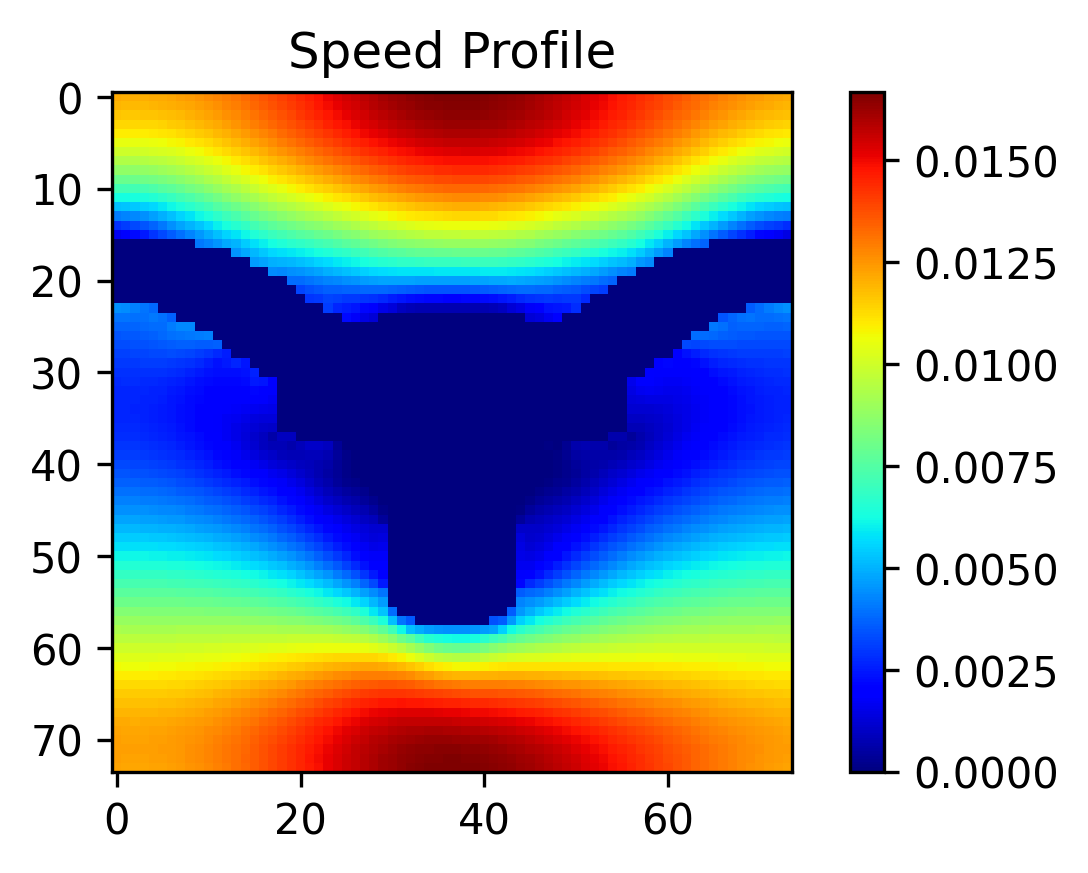

In [31]:
# from plotting_utils import plot_quiver
profile_fig = plot_profile(u, cmap='jet')

## Calculate Permeability

Once we have the full velocity field, we can easily calculate the absolute permeability.



In [14]:
# Calculate permeability

Let's use the Porespy library to generate some blobs

In [23]:
def generate_blobs(phi):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  obstacle = torch.tensor(~ps.generators.blobs(shape=[200, 200], porosity=phi)).to(device)
  #obstacle = torch.tensor(fromfunction(obstacle_fun(cx,cy,r),(nx, ny)))
  plt.imshow(obstacle.cpu(), cmap='binary')
  plt.colorbar()
  return obstacle

phi_widget = widgets.FloatSlider(value=0.5, min=0.5, max=0.86, description='Porosity', 
                                 continuous_update=False, step=0.01)

blobs = widgets.interactive(generate_blobs, {'manual': True},
                                       phi=phi_widget)

blobs


interactive(children=(FloatSlider(value=0.5, continuous_update=False, description='Porosity', max=0.86, min=0.…

In [16]:
u_x, u_y, u = run_lbm(blobs.result)

RuntimeError: ignored

In [ ]:
profile_fig = plot_profile(u, vmin=0, cmap='jet')
obstacle_nan = torch.clone(obstacle.cpu())



# Multiphase Lattice Boltzmann Method

We use the Shan-Chen Model



Other models include:
* Color Model
* Free Energy Based models


Today, we will be working with our in-house code — Multiphase Lattice Boltzmann Method - UT (MPLBM-UT).

MPLBM Workflow

<img src='https://ars.els-cdn.com/content/image/1-s2.0-S2352711022000668-gr1.jpg'>